In [8]:
from __future__ import division
import xgboost as xgb
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())

0it [00:00, ?it/s]


In [27]:
df_train = pd.read_csv("./old/train_data.csv")
df_test = pd.read_csv("./old/test_data.csv")

In [33]:
def collate_similar_feats(df):
    
    sports_feats = ["genre_Athletics" , "genre_Badminton" , "genre_Boxing" , "genre_Cricket" , "genre_Football" , "genre_Formula1" , "genre_FormulaE" , "genre_Hockey" , "genre_IndiaVsSa" , "genre_Kabaddi" , "genre_Sport" , "genre_Swimming" , "genre_Table Tennis" , "genre_Tennis" , "genre_Volleyball"]
    df["generated_sports"] = 0
    
    celeb_feats = ["genre_TalkShow", "genre_Reality", "genre_Awards"]
    df["generated_celeb"] = 0

    drama_feats = ["genre_Drama", "genre_Romance", "genre_Family"]
    df["generated_drama"] = 0

    science_feats = ["genre_Documentary", "genre_Science", "genre_Wildlife"]
    df["generated_science"] = 0

    action_feats = ["genre_Action", "genre_Thriller"]
    df["generated_action"] = 0

    for i in sports_feats:
        df["generated_sports"]  = df["generated_sports"] + df[i]
        df.drop(i, axis = 1, inplace = True)
    df["sports_ratio"] = df["generated_sports"]/df["sum_wt"]
    
    for i in celeb_feats:
        df["generated_celeb"]  = df["generated_celeb"] + df[i]
        df.drop(i, axis = 1, inplace = True)
    df["celeb_ratio"] = df["generated_celeb"]/df["sum_wt"]

    for i in drama_feats:
        df["generated_drama"]  = df["generated_drama"] + df[i]
        df.drop(i, axis = 1, inplace = True)
    df["drama_ratio"] = df["generated_drama"]/df["sum_wt"]

    for i in science_feats:
        df["generated_science"]  = df["generated_science"] + df[i]
        df.drop(i, axis = 1, inplace = True)
    df["science_ratio"] = df["generated_science"]/df["sum_wt"]

    for i in action_feats:
        df["generated_action"]  = df["generated_action"] + df[i]
        df.drop(i, axis = 1, inplace = True)
    df["action_ratio"] = df["generated_action"]/df["sum_wt"]

    return df

In [34]:
def collate_tod_feats(df):
    
    late_night_feats = ["tod_0", "tod_1", "tod_2", "tod_3", "tod_4", "tod_5"]
    df["generated_late_night"] = 0
    
    morning_feats = ["tod_6", "tod_7", "tod_8", "tod_9", "tod_10", "tod_11"]    
    df["generated_morning"] = 0
    
    afternoon_feats = ["tod_12", "tod_13", "tod_14", "tod_15", "tod_16", "tod_17"]    
    df["generated_afternoon"] = 0
    
    evening_feats = [ "tod_18", "tod_19", "tod_20", "tod_21", "tod_22", "tod_23"]    
    df["generated_evening"] = 0
    
    for i in late_night_feats:
        df["generated_late_night"]  = df["generated_late_night"] + df[i]
        df.drop(i, axis = 1, inplace = True)

    for i in morning_feats:
        df["generated_morning"]  = df["generated_morning"] + df[i]
        df.drop(i, axis = 1, inplace = True)

    for i in afternoon_feats:
        df["generated_afternoon"]  = df["generated_afternoon"] + df[i]
        df.drop(i, axis = 1, inplace = True)

    for i in evening_feats:
        df["generated_evening"]  = df["generated_evening"] + df[i]
        df.drop(i, axis = 1, inplace = True)

    sum_time_wt = df_train.generated_late_night + df_train.generated_morning + df_train.generated_afternoon + df_train.generated_evening

    df["late_night_ratio"] = df["generated_late_night"]/sum_time_wt
    df["morning_ratio"] = df["generated_morning"]/sum_time_wt
    df["afternoon_ratio"] = df["generated_afternoon"]/sum_time_wt
    df["evening_ratio"] = df["generated_evening"]/sum_time_wt
    
    return df

In [35]:
def collate_weekend_weekday(df):
    
    weekday_feats = ["dow_1", "dow_2", "dow_3", "dow_4", "dow_5"]
    df["weekday"] = 0

    weekend_feats = ["dow_6", "dow_7"]
    df["weekend"] = 0

    for i in weekday_feats:
        df["weekday"]  = df["weekday"] + df[i]
        df.drop(i, axis = 1, inplace = True)

    for i in weekend_feats:
        df["weekend"]  = df["weekend"] + df[i]
        df.drop(i, axis = 1, inplace = True)
    
    df["weekend_perc"] = df["weekend"]/(df["weekend"] + df["weekday"])
    df["weekend_ratio"] = df["weekend"]/df["weekday"]
#     df["weekend_weekday_diff"] = df["weekend"] - df["weekday"]
    
    return df

In [29]:
def title_analysis(row):
    
    title_dict = {}
    
    for title in row.titles.split(","):

        try: #to ignore blanks

            title_name, title_wt = title.split(":")
            title_dict[str(title_name)] = int(title_wt)

        except:
            pass

    if sum(title_dict.values()) > 0:
        titles_gt_600 = sum( x >= 600 for x in title_dict.values() )
        titles_mean = np.mean(title_dict.values())
        titles_median = np.median(title_dict.values())    
        titles_max = max(title_dict.values())    
        titles_max_perc = titles_max/sum(title_dict.values())

        return pd.Series({
            "titles_gt_600": titles_gt_600,
            "titles_mean": titles_mean,
            "titles_median": titles_median,
            "titles_max": titles_max,
            "titles_max_perc": titles_max_perc
        })
    else:
        return pd.Series({
            "titles_gt_600": 0,
            "titles_mean": 0,
            "titles_median": 0,
            "titles_max": 0,
            "titles_max_perc": 0
        })
    
train_data = pd.read_json('train_data.json',orient="index")
train_title = train_data.progress_apply(title_analysis, axis = 1)
%reset_selective -f train_data
train_title.index = df_train.index
df_train = pd.concat([df_train, train_title], axis = 1)

test_data = pd.read_json('test_data.json',orient='index')
test_title = test_data.progress_apply(title_analysis, axis = 1)
%reset_selective -f test_data
test_title.index = df_test.index
df_test = pd.concat([df_test, test_title], axis = 1)

In [30]:
df_train.head()

,ID,segment,genre_Action,genre_Athletics,genre_Awards,genre_Badminton,genre_Boxing,genre_Comedy,genre_Cricket,genre_Crime,...,title_count,genres_count,cities_count,tod_count,dow_count,titles_gt_600,titles_max,titles_max_perc,titles_mean,titles_median
0,train-1,0,0,0,0,0,0,0,82379,0,...,60,3,2,14,7,19.0,9186.0,0.111071,2120.615385,596.0
1,train-10,0,0,0,0,0,0,0,15640,0,...,70,2,3,16,7,7.0,4439.0,0.311400,279.509804,76.0
2,train-100,0,0,0,0,0,0,0,0,0,...,2,2,1,3,1,1.0,4129.0,0.996861,2071.000000,2071.0
3,train-1000,0,0,0,0,0,0,0,7690,0,...,8,2,3,6,5,5.0,2878.0,0.344753,1043.500000,679.5
4,train-10000,0,0,0,0,0,0,0,3283,0,...,11,3,2,9,5,3.0,5449.0,0.537960,920.818182,292.0


In [36]:
df_train = collate_similar_feats(df_train)
df_test = collate_similar_feats(df_test)

In [37]:
df_train = collate_tod_feats(df_train)
df_test = collate_tod_feats(df_test)

In [38]:
df_train = collate_weekend_weekday(df_train)
df_test = collate_weekend_weekday(df_test)

In [39]:
df_train.to_csv("./new/train_data.csv", index = False)
df_test.to_csv("./new/test_data.csv", index = False)

In [40]:
import seaborn as sns
corr = df_train.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

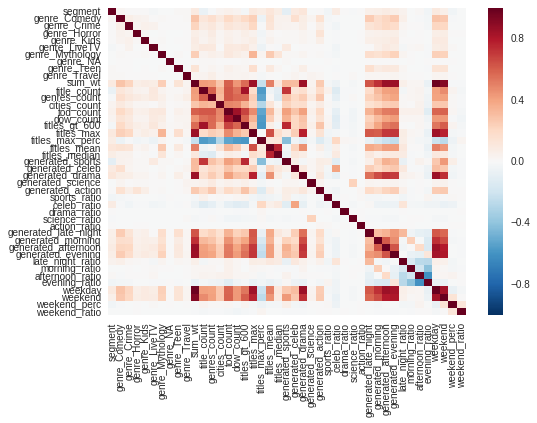

In [41]:
import matplotlib.pyplot as plt
plt.show()

In [72]:
np.mean(df_train[df_train.segment == 0].title_count)

12.115478091423313